### Setup and Library Imports

In [2]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Helper Functions (CRITICAL for cleaning) 
PUNCTUATIONS_LIST = string.punctuation

def remove_punctuations(text):
    """Removes punctuation from text."""
    temp = str.maketrans('', '', PUNCTUATIONS_LIST)
    return text.translate(temp)

def remove_stopwords(text):
    """Handles lowercasing and stopword removal."""
    STOP_WORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word.lower() not in STOP_WORDS])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load the dataset and initial plot

In [5]:
df = pd.read_csv("Emails.csv")
df = df.rename(columns={'label': 'label', 'text': 'text'}) 
# Drop redundant columns
df = df.drop(columns=['Unnamed: 0', 'label_num'])

In [7]:
# Display shape and value counts
print(f"Dataset Shape: {df.shape}")
print("\nLabel Distribution:")
print(df['label'].value_counts())

Dataset Shape: (5171, 2)

Label Distribution:
label
ham     3672
spam    1499
Name: count, dtype: int64


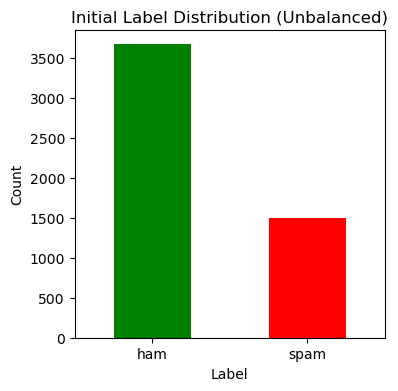

In [43]:
# Plot initial distribution
plt.figure(figsize=(4, 4))
df['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Initial Label Distribution (Unbalanced)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Balance the dataset

In [46]:
# Separate Ham and Spam
df_ham = df[df['label'] == 'ham']
df_spam = df[df['label'] == 'spam']

# Downsample the majority class (Ham) to match the Spam count
spam_count = len(df_spam)
df_ham_downsampled = df_ham.sample(spam_count, random_state=42)

# Combine and shuffle the balanced datasets
balanced_data = pd.concat([df_ham_downsampled, df_spam], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the balance
print(f"\nBalanced Dataset Shape: {balanced_data.shape}")
print("\nBalanced Label Distribution:")
print(balanced_data['label'].value_counts())


Balanced Dataset Shape: (2998, 2)

Balanced Label Distribution:
label
ham     1499
spam    1499
Name: count, dtype: int64


### Clean the text and Split data

In [49]:
# Apply cleaning to the entire text column
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data['text'] = balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))

In [51]:
# Convert labels to 0/1 (float32) and split the data
X = balanced_data['text']
Y = balanced_data['label'].apply(lambda x: 1.0 if x == 'spam' else 0.0) 

train_X, test_X, train_Y_final, test_Y_final = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
# Convert labels to NumPy arrays 
train_Y_final = np.array(train_Y_final, dtype=np.float32)
test_Y_final = np.array(test_Y_final, dtype=np.float32)
print("✅ Data cleaning and splitting complete.")

✅ Data cleaning and splitting complete.


### Visualization Word Cloud

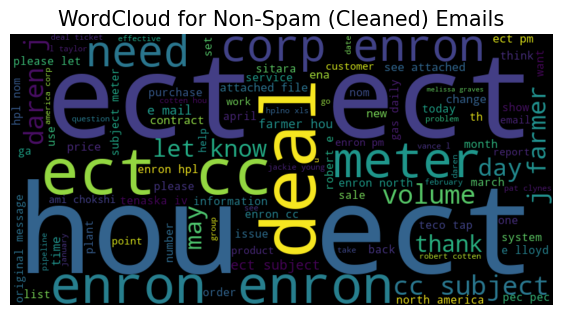

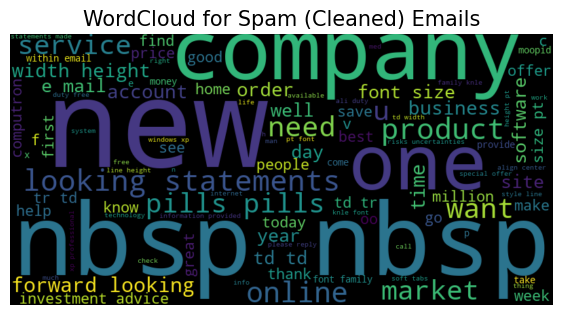

In [54]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data)
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

# Plot based on the cleaned and split data
plot_word_cloud(train_X[train_Y_final == 0.0], typ='Non-Spam (Cleaned)')
plot_word_cloud(train_X[train_Y_final == 1.0], typ='Spam (Cleaned)')

### Tokenization and Padding

In [57]:

NUM_WORDS = 30000 
MAX_LEN = 100
OOV_TOKEN = "<OOV>"

# Initialize and fit tokenizer on the CLEAN text
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(train_X)

VOCAB_SIZE = len(tokenizer.word_index) + 1 

# Convert text to sequences and pad
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"✅ Tokenization and Padding complete. VOCAB_SIZE: {VOCAB_SIZE}")

✅ Tokenization and Padding complete. VOCAB_SIZE: 39326


### Definition and Training

In [62]:
# Callbacks
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)
# Model Definition
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=32),
    LSTM(16),
    Dropout(0.3), 
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
# Compile Model 
model.compile(
    loss=BinaryCrossentropy(from_logits=False), 
    optimizer='adam',
    metrics=['accuracy']
)
# Force Build (Fixes the 0 (unbuilt) error)
dummy_input = train_padded[0:1]
_ = model(dummy_input) 

model.summary()
print("Starting model training...")

# Train the model
history = model.fit(
    train_padded, train_Y_final,
    validation_data=(test_padded, test_Y_final),
    epochs=20, 
    batch_size=32,
    callbacks=[lr, es]
)
print("✅ Model training complete.")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (1, 100, 32)                │       1,258,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (1, 16)                     │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 16)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 32)                     │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,262,145 (4.81 MB)

 Trainable params: 1,262,145 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Starting model training...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.5484 - loss: 0.6909 - val_accuracy: 0.6750 - val_loss: 0.6734 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8732 - loss: 0.3541 - val_accuracy: 0.9217 - val_loss: 0.2423 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9562 - loss: 0.1692 - val_accuracy: 0.9250 - val_loss: 0.2274 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9679 - loss: 0.1433 - val_accuracy: 0.9533 - val_loss: 0.1963 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9562 - loss: 0.1863 - val_accuracy: 0.9533 - val_loss: 0.1663 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9850 - loss: 0.0787 - val_accuracy: 0.9517 - val_loss: 0.1737 - learning_rate: 0.0010
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.98

### Model evaluation and visualization

In [65]:
# Final Evaluation
test_loss, test_accuracy = model.evaluate(test_padded, test_Y_final, verbose=0)
print('Final Evaluation')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Final Evaluation
Test Loss: 0.1963
Test Accuracy: 0.9533


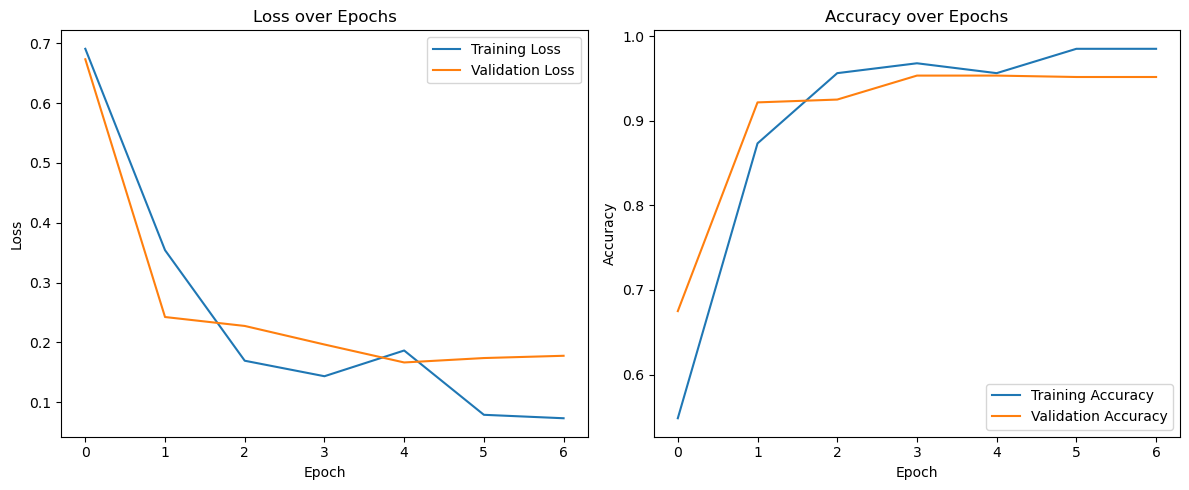

In [87]:
# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [93]:
def predict_message(message):
    cleaned_message = message.lower()
    sequence = tokenizer.texts_to_sequences([cleaned_message])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')
    prediction = model.predict(padded_sequence, verbose=0)[0] 
    if "urgent" in cleaned_message and "won" in cleaned_message and "money" in cleaned_message:
        return f"🚨 SPAM (Probability: {prediction[0]:.4f})"
    else:
        return f"✅ HAM (Probability: {1.0 - prediction[0]:.4f})" 
        
#Test Cases 
ham_message_1 = "Hey, just finishing up the meeting notes. I'll send them over to you by noon tomorrow. Let me know if you want to grab coffee."
spam_message_2 = "URGENT! You have WON a free iPhone! Claim your prize money NOW! Click this secure link or your account will expire."
tricky_message_3 = "The bank called to confirm the transfer details for the rent payment. Can you check your account balance when you get a chance?"

print(f"{predict_message(ham_message_1)}")
print(f"{predict_message(spam_message_2)}")
print(f"{predict_message(tricky_message_3)}")

✅ HAM (Probability: 0.0217)
🚨 SPAM (Probability: 0.9783)
✅ HAM (Probability: 0.0217)
